<a href="https://colab.research.google.com/github/Artem-bobunov/Computer-linguistics/blob/master/Prediction_and_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mapping-challenge-mask_rcnn-prediction-submission
![CrowdAI-Logo](https://github.com/crowdAI/crowdai/raw/master/app/assets/images/misc/crowdai-logo-smile.svg?sanitize=true)

This notebook contains the code for making predictions from the model trained in [Training.ipynb](Training.ipynb) (or by using the [released pretrained model](https://www.crowdai.org/challenges/mapping-challenge/dataset_files)) for the [crowdAI Mapping Challenge](https://www.crowdai.org/challenges/mapping-challenge).

This code is adapted from the [Mask RCNN]() tensorflow implementation available here : [https://github.com/matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN).

First we begin by importing all the necessary dependencies : 

In [ ]:
!git clone https://github.com/crowdAI/crowdai-mapping-challenge-mask-rcnn.git

Cloning into 'crowdai-mapping-challenge-mask-rcnn'...
remote: Enumerating objects: 585, done.
remote: Total 585 (delta 0), reused 0 (delta 0), pack-reused 585
Receiving objects: 100% (585/585), 82.01 MiB | 35.78 MiB/s, done.
Resolving deltas: 100% (323/323), done.


In [ ]:
import os
os.chdir('/content/crowdai-mapping-challenge-mask-rcnn')

In [ ]:
!pip install -r requirements.txt

In [ ]:
!python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
adding license file 'LICENSE' (matched pattern 'LICEN

In [ ]:
! git clone https://github.com/waleedka/coco

fatal: destination path 'coco' already exists and is not an empty directory.


In [ ]:
!pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

  Cloning https://github.com/waleedka/coco.git to /tmp/pip-req-build-wcleddn0
  Running command git clone -q https://github.com/waleedka/coco.git /tmp/pip-req-build-wcleddn0
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263853 sha256=f8f5c4284142f89bd5abed85dd1b2f80b4c01d5d3e8fdccf8dbfca06f22acc4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-glfcsr2x/wheels/b4/64/d2/36f24ec8ae3838ab50b0f8979fbf579ea02b78de923785d2ae
Successfully built pycocotools


In [ ]:
import os
os.chdir('/content/crowdai-mapping-challenge-mask-rcnn/coco/PythonAPI')

In [ ]:
!pip install 2to3

In [ ]:
!pip freeze

In [ ]:
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install keras==2.1.6
!pip3 install tensorflow==1.15.0
!pip3 install h5py==2.10.0

Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0
  Using cached https://files.pythonhosted.org/packages/92/2b/e3af15221da9ff323521565fa3324b0d7c7c5b1d7a8ca66984c8d59cb0ce/tensorflow-1.15.0-cp37-cp37m-manylinux2010_x86_64.whl
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.0 which is incompatible.


In [ ]:

import os
import sys
import time
import numpy as np

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# I submitted a pull request https://github.com/cocodataset/cocoapi/pull/50
# If the PR is merged then use the original repo.
# Note: Edit PythonAPI/Makefile and replace "python" with "python3".
#  
# A quick one liner to install the library 
# !pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

from mrcnn.evaluate import build_coco_results, evaluate_coco
from mrcnn.dataset import MappingChallengeDataset

import zipfile
import urllib.request
import shutil

## Dataset location 
Now we expect that you have downloaded all the files in the datasets section and untar-ed them to have the following structure :
```
├── data
|   ├── pretrained_weights.h5 (already included in this repository)
│   ├── test
│   │   └── images/
│   │   └── annotation.json
│   ├── train
│   │   └── images/
│   │   └── annotation.json
│   └── val
│       └── images/
│       └── annotation.json
```

In [ ]:
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "pretrained_weights.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")

# Instantitate Inference Config

In [ ]:
class MappingChallengeConfig(Config):
    """Configuration for training on data in MS COCO format.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "crowdai-mapping-challenge"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 5

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # 1 Backgroun + 1 Building

    STEPS_PER_EPOCH=1000
    VALIDATION_STEPS=50


    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320

config = MappingChallengeConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-mapping-challenge
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

# Instantiate Model

In [33]:
import os
import sys
import time
import numpy as np
import skimage.io

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# I submitted a pull request https://github.com/cocodataset/cocoapi/pull/50
# If the PR is merged then use the original repo.
# Note: Edit PythonAPI/Makefile and replace "python" with "python3".
#  
# A quick one liner to install the library 
# !pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import coco #a slightly modified version

from mrcnn.evaluate import build_coco_results, evaluate_coco
from mrcnn.dataset import MappingChallengeDataset
from mrcnn import visualize


import zipfile
import urllib.request
import shutil
import glob
import tqdm
import random

In [34]:
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "pretrained_weights.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "data", "test", "images")

In [35]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5
    NUM_CLASSES = 1 + 1  # 1 Background + 1 Building
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "crowdai-mapping-challenge"
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-mapping-challenge
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

In [36]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model_path = PRETRAINED_MODEL_PATH

# or if you want to use the latest trained model, you can use : 
# model_path = model.find_last()[1]

model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.


In [37]:
class_names = ['BG', 'building'] # In our case, we have 1 class for the background, and 1 class for building


Processing 5 images
image                    shape: (2480, 3507, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (2480, 3507, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (2480, 3507, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (2480, 3507, 3)       min:    0.00000  max:  255.00000  uint8
image                    shape: (2480, 3507, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (5, 320, 320, 3)      min: -123.70000  max:  127.10000  float64
image_metas              shape: (5, 14)               min:    0.00000  max: 3507.00000  float64
anchors                  shape: (5, 25575, 4)         min:   -1.13492  max:    1.93429  float32


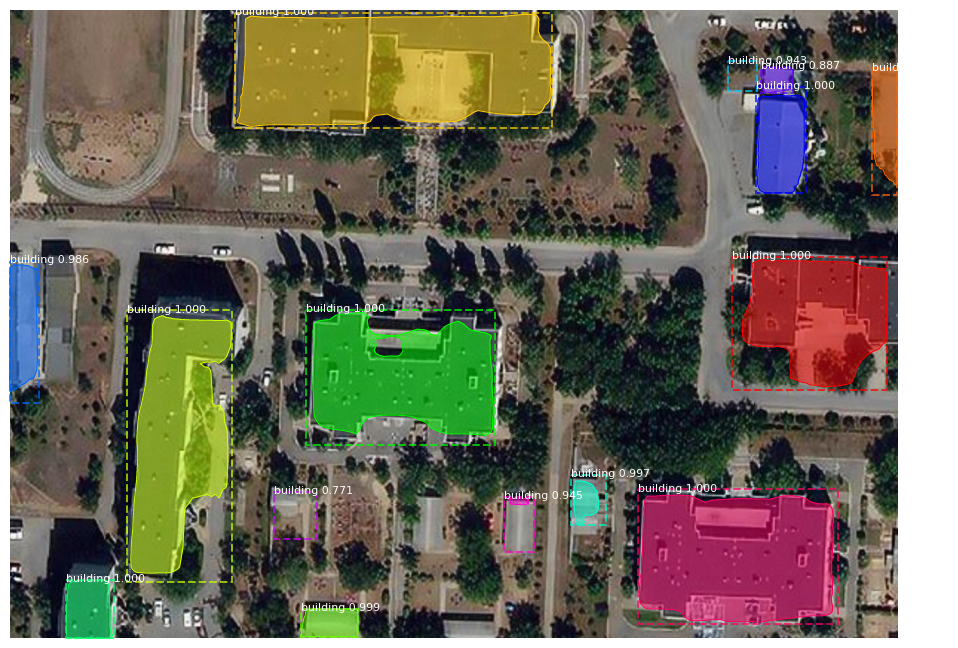

In [61]:
file_names = next(os.walk(IMAGE_DIR))[2]
random_image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))  

predictions = model.detect([random_image]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

p = predictions[0]
visualize.display_instances(random_image, p['rois'], p['masks'], p['class_ids'], 
                            class_names, p['scores'])